# NER with BiLSTM and CRF

Ref: 
- https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf    
- https://github.com/tensorflow/addons/issues/1769    
- https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede


Dataset: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Nvidia Setup Error with Cuda 11.2:
- https://medium.com/mlearning-ai/tensorflow-2-4-with-cuda-11-2-gpu-training-fix-87f205215419

In [1]:
import pandas as pd
import numpy as np

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import Model, Input

/opt/envs/ai4e/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [4]:
! ls ../data/ner/entity-annotated-corpus/archive/

ner.csv  ner_dataset.csv


In [5]:
DATA_DIR = '../data/ner/entity-annotated-corpus/archive/'

In [6]:
# Read the dataset
df = pd.read_csv(DATA_DIR + "ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [7]:
# Narrow down the column to NER alone
data = df[['sentence_idx','word','tag']]
data.head(5)

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [8]:
# Count number of NER labels
data['tag'].value_counts()

O        889973
B-geo     37525
B-tim     20193
B-org     20184
I-per     17382
B-per     17011
I-org     16537
B-gpe     16392
I-geo      7409
I-tim      6298
B-art       434
B-eve       348
I-eve       297
I-art       280
I-gpe       229
B-nat       226
I-nat        76
Name: tag, dtype: int64

In [9]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
print(sentences[1:3])

[[('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O'), ('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O')], [('They', 'O'), ('marched', 'O'), ('from', 'O'), ('the', 'O

In [11]:
words = list(set(data["word"].values))
n_words = len(words)

tags = list()
for tag in set(data["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

In [12]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [13]:
maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post", value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
maxlen, n_words, n_tags

(140, 30173, 18)

In [15]:
# from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
inputs = Input(shape=(maxlen,))
word_embedding_size = 150

# Embedding Layer
model = tf.keras.layers.Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=140)(inputs)

# BI-LSTM Layer
model = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=tf.keras.initializers.HeNormal()))(model)
model = tf.keras.layers.LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=tf.keras.initializers.HeNormal())(model)

# TimeDistributed Layer
model = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags, activation="relu"))(model)  

# CRF Layer
# crf = tensorflow_addons.layers.CRF(n_tags)

crf = CRF(n_tags, sparse_target=True)
outputs = crf(model)  # output
print(outputs[1].shape)

model = Model(inputs, outputs)
model.summary()

(140, 18)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 140, 150)          4525950   
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 300)          361200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 140, 300)          721200    
_________________________________________________________________
time_distributed (TimeDistri (None, 140, 18)           5418      
_________________________________________________________________
crf (CRF)                    (None, 140, 18)           324       
Total params: 5,614,092
Trainable params: 5,614,092
Non-trainable params: 0
_________________________________________

In [16]:
#Optimiser 
adam = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])



# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Epoch 1/20
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
99/99 [==============================] - 143s 1s/step - loss: 45.8670 - viterbi_accuracy: 0.9452 - accuracy: 0.9583 - val_loss: 312.9725 - val_viterbi_accuracy: 0.9669 - val_accuracy: 0.9669

Epoch 00001: val_accuracy improved from -inf to 0.96694, saving model to ner-bi-lstm-td-model-0.97.hdf5
Epoch 2/20
99/99 [==============================] - 208s 2s/step - loss: 24.7947 - viterbi_accuracy: 0.9674 - accuracy: 0.9674 - val_loss: 312.2083 - val_viterbi_accuracy: 0.9667 - val_accuracy: 0.9668

Epoch 00002: val_accuracy did not improve from 0.96694
Epoch 3/20
99/99 [==============================] - 205s 2s/step - loss: 17.7076 - viterbi_accuracy: 0.9692 - accuracy: 0.9692 - val_loss: 310.6079 - val_viterbi_accuracy: 0.9733 - val_accuracy: 0.9746

Epoch 00003: val_accuracy improved from 0.96694 to 0.97465, saving model to ner-bi-lstm-td-mod

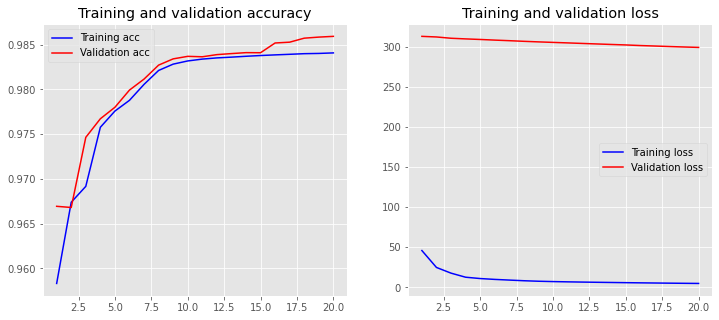

In [17]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [18]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

220/220 [==============================] - 105s 467ms/step


In [19]:
! pip install seqeval

In [20]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 60.6%


In [21]:
! pip install sklearn_crfsuite

In [22]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/opt/envs/ai4e/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/opt/envs/ai4e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/envs/ai4e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        88
       B-eve       0.00      0.00      0.00        79
       B-geo       0.81      0.87      0.84      7490
       B-gpe       0.94      0.92      0.93      3434
       B-nat       0.00      0.00      0.00        47
       B-org       0.30      0.53      0.38      4026
       B-per       0.82      0.77      0.79      3339
       B-tim       0.28      0.02      0.04      3989
       I-art       0.00      0.00      0.00        58
       I-eve       0.00      0.00      0.00        63
       I-geo       0.63      0.68      0.66      1502
       I-gpe       0.00      0.00      0.00        63
       I-nat       0.00      0.00      0.00        16
       I-org       0.57      0.39      0.46      3296
       I-per       0.82      0.79      0.80      3437
       I-tim       0.00      0.00      0.00      1259
           O       1.00      1.00      1.00    952854

    accuracy              

/opt/envs/ai4e/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1


In [24]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])

In [25]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    

tag:unk
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-geo
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-geo
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-org
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:O
	 TN:         0	FP:         0
	 FN:         0	TP:    978004
tag:B-org
	 TN:         0	FP:         0
	 FN:         0	TP:      7036
tag:I-nat
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-per
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-tim
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-eve
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:I-art
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-gpe
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:B-tim
	 TN:         0	

In [26]:
!ls

BiLSTM-CRF.ipynb    ner-bi-lstm-td-model-0.97.hdf5
LegalER.ipynb	    ner-bi-lstm-td-model-0.98.hdf5
NER-spaCy.ipynb     ner-bi-lstm-td-model-0.99.hdf5
NLP-spaCy.ipynb     untitled.txt
default_config.cfg
